# **REAL TIME ANALYTICS - CSE3069**

# **CUSTOMER CHURN PREDICTION**


# **Group Members**

*Nalla Vedavathi - 19MIA1106*

*Sneha M - 19MIA1101*

Installation of Spark

Installation of required packages

Checking Spark status

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


Set Java Home

Perform Testing

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [ ]:
import pyspark
from pyspark.context import SparkContext 
from pyspark import SparkConf 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[4]"))

Initialise the Neccesary Libraries

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from time import time

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import warnings
warnings.filterwarnings("ignore")

Connect to the GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
telecomdata = pd.read_csv("/content/drive/MyDrive/Customer Churn Prediction/new/CustomerAtrritionData.csv")
telecomdata.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [ ]:
Attritiondata = spark.read.csv("/content/drive/MyDrive/Customer Churn Prediction/new/CustomerAtrritionData.csv", header='true', inferSchema='true')
Attritiondata .printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [ ]:
Attritiondata.select("*").toPandas().head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
State,LA,IN,NY,SC,HI,AK,MI,ID,VA,WI
Account length,117,65,161,111,49,36,65,119,10,68
Area code,408,415,415,415,510,408,415,415,408,415
International plan,No,No,No,No,No,No,No,No,No,No
Voice mail plan,No,No,No,No,No,Yes,No,No,No,No
Number vmail messages,0,0,0,0,0,30,0,0,0,0
Total day minutes,184.5,129.1,332.9,110.4,119.3,146.3,211.3,159.1,186.1,148.8
Total day calls,97,137,67,103,117,128,120,114,112,70
Total day charge,31.37,21.95,56.59,18.77,20.28,24.87,35.92,27.05,31.64,25.3
Total eve minutes,351.6,228.5,317.8,137.3,215.1,162.5,162.6,231.3,190.2,246.5


In [ ]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(telecomdata.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [ ]:
dataoveriew(telecomdata, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 3333

Number of features: 20

Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

Missing values: 0

Unique values:
State                       51
Account length             212
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       46
Total day minutes         1667
Total day calls            119
Total day charge          1667
Total eve minutes         1611
Total eve calls            123
Total eve charge          1440
Total night minutes       1591
Total night calls          120
Total night charge         933
Total intl minutes         16

In [ ]:
Attritiondata.agg({'Account length': 'min','Number vmail messages': 'min','Total day minutes': 'min', 'Total day calls': 'min', 'Total day charge': 'min', 'Total eve minutes': 'min', 'Total eve calls': 'min', 'Total eve charge': 'min',\
                   'Total night minutes': 'min',\
                   'Total night calls': 'min',\
                   'Total night charge': 'min',\
                   'Total intl minutes': 'min',\
                   'Total intl calls': 'min',\
                   'Total intl charge': 'min',\
                   'Customer service calls': 'min'}).collect()

[Row(min(Account length)=1, min(Total day calls)=0, min(Total day minutes)=0.0, min(Total intl minutes)=0.0, min(Total night minutes)=23.2, min(Total eve charge)=0.0, min(Number vmail messages)=0, min(Total eve minutes)=0.0, min(Total eve calls)=0, min(Total night charge)=1.04, min(Customer service calls)=0, min(Total day charge)=0.0, min(Total intl calls)=0, min(Total intl charge)=0.0, min(Total night calls)=33)]

In [ ]:
Attritiondata.agg({'Account length': 'max','Number vmail messages': 'max','Total day minutes': 'max', 'Total day calls': 'max', 'Total day charge': 'max', 'Total eve minutes': 'max', 'Total eve calls': 'max', 'Total eve charge': 'max',\
                   'Total night minutes': 'max',\
                   'Total night calls': 'max',\
                   'Total night charge': 'max',\
                   'Total intl minutes': 'max',\
                   'Total intl calls': 'max',\
                   'Total intl charge': 'max',\
                   'Customer service calls': 'max'}).collect()

[Row(max(Account length)=243, max(Total day calls)=165, max(Total day minutes)=350.8, max(Total intl minutes)=20.0, max(Total night minutes)=395.0, max(Total eve charge)=30.91, max(Number vmail messages)=51, max(Total eve minutes)=363.7, max(Total eve calls)=170, max(Total night charge)=17.77, max(Customer service calls)=9, max(Total day charge)=59.64, max(Total intl calls)=20, max(Total intl charge)=5.4, max(Total night calls)=175)]

Summary Statistics

In [ ]:
numeric_features = [t[0] for t in Attritiondata.dtypes if t[1] == 'int' or t[1] == 'double']

Attritiondata.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,3333,101.06480648064806,39.82210592859559,1,243
Area code,3333,437.18241824182417,42.37129048560658,408,510
Number vmail messages,3333,8.099009900990099,13.688365372038598,0,51
Total day minutes,3333,179.77509750975133,54.46738920237139,0.0,350.8
Total day calls,3333,100.43564356435644,20.069084207300897,0,165
Total day charge,3333,30.562307230723,9.259434553930499,0.0,59.64
Total eve minutes,3333,200.98034803480334,50.71384442581189,0.0,363.7
Total eve calls,3333,100.11431143114311,19.922625293943106,0,170
Total eve charge,3333,17.083540354035403,4.310667643110341,0.0,30.91


In [ ]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
trace = go.Pie(labels = telecomdata["Churn"].value_counts().keys().tolist(),
               values = telecomdata["Churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','red'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = 0.5
              )
layout = go.Layout(dict(title = "Customer churn in training data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)

fig.show(renderer="colab")

Correlations

In [ ]:
sampled_data = Attritiondata.select(numeric_features).sample(False, 0.10)

print("The sampled dataset contains {} samples.".format(sampled_data.count()))

The sampled dataset contains 307 samples.


In [ ]:
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Attrition Attributes Pairwise Plots', fontsize=14, fontweight='bold');

Output hidden; open in https://colab.research.google.com to view.

It's obvious that there are several highly correlated fields, ie Total day minutes and Total day charge. Such correlated data will not be very beneficial for the model training runs, so we are going to remove them. We will do so by dropping one column of each pair of correlated variables along with the State and Area code columns.

Data preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Removing correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 
               'Total night charge', 'Total intl charge']
   
telecomdata = telecomdata.drop(columns = col_to_drop, axis = 1)


#target column
target_col = ["Churn"]

#number of levels in feature to be a categorical feature
nlevels = 6

#Separating categorical and numerical columns
#categorical columns
cat_cols = list(set(telecomdata.nunique()[telecomdata.nunique()<nlevels].keys().tolist() 
                    + telecomdata.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in telecomdata.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols = telecomdata.nunique()[telecomdata.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    telecomdata[i] = le.fit_transform(telecomdata[i])
    

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telecomdata[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

scaled_test = std.transform(telecomdata[num_cols])
scaled_test = pd.DataFrame(scaled_test, columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telecomdata.copy()
telecomdata = telecomdata.drop(columns = num_cols, axis = 1)
telecomdata = telecomdata.merge(scaled, left_index=True, right_index=True, how = "left")

In [ ]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Training variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
figure.show(renderer="colab")

Correlation matrix

In [ ]:
#correlation
correlation = telecomdata.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Visualizing data with principal components Analysis

In [ ]:
def pca_scatter(pcadf, targetfeature, targetlabel, color):
    tracer = go.Scatter(x = pcadf[pcadf[targetfeature]==targetlabel]["PC1"],
                        y = pcadf[pcadf[targetfeature]==targetlabel]["PC2"],
                        name = targetlabel, mode = "markers",
                        marker = dict(color = color, line = dict(width = .5), symbol = "diamond-open"),
                       )
    return tracer

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telecomdata[[i for i in telecomdata.columns if i not in target_col]]
Y = telecomdata[target_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])
pca_data = pca_data.merge(Y, left_index=True, right_index=True, how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1: "Churn", 0: "Not churn"})

layout = go.Layout(dict(title = "Visualizing data with PCA",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "first principal component (PC1)",
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "second principal component (PC2)",
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        height = 400
                       )
                  )
trace1 = pca_scatter(pca_data, 'Churn', 'Churn', 'red')
trace2 = pca_scatter(pca_data, 'Churn', 'Not churn', 'royalblue')
data = [trace2, trace1]
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

Binary variable distribution in customer churn - Radar Chart

In [ ]:
def plot_radar(df, aggregate, title):
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns = ["feature", "yes"]
    data_frame_x["no"] = data_frame.shape[0] - data_frame_x["yes"]
    data_frame_x = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's (yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill = "toself", 
                             name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's (no)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill = "toself", 
                             name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title, height = 600, width = 600))
    
    data = [trace2, trace1]
    fig = go.Figure(data=data, layout=layout)
    # py.iplot(fig)
    fig.show(renderer="colab")

In [ ]:
#separating binary columns
bi_cs = telecomdata.nunique()[telecomdata.nunique() == 2].keys()
dat_rad = telecomdata[bi_cs]

#plotting radar chart for churn and not churn customers (binary variables)
plot_radar(dat_rad, 1, "Churn customers")
plot_radar(dat_rad, 0, "Not churn customers")

# Model Building

In [ ]:
def telecom_churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn", "Churn"],
                        y = ["Not churn", "Churn"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        

    fig.show(renderer="colab")

    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold

#defining the studied or used independent features (columns) as well the target  
cols = [i for i in telecomdata.columns if i not in target_col]
target_col = ['Churn']

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(telecomdata[cols], telecomdata[target_col], 
                                                    test_size = .25, random_state = 111)

#splitting the no scaled principal training dataset to subtrain and subtest datasets
x_train_og, x_test_og, y_train_og, y_test_og = train_test_split(df_telcom_og[cols], telecomdata[target_col],
                                                                test_size = .25, random_state = 111)

Logistic Regression

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       713
           1       0.40      0.18      0.25       121

    accuracy                           0.84       834
   macro avg       0.64      0.57      0.58       834
weighted avg       0.80      0.84      0.82       834

Accuracy Score: 0.841726618705036
Area under curve: 0.5677674359301288 



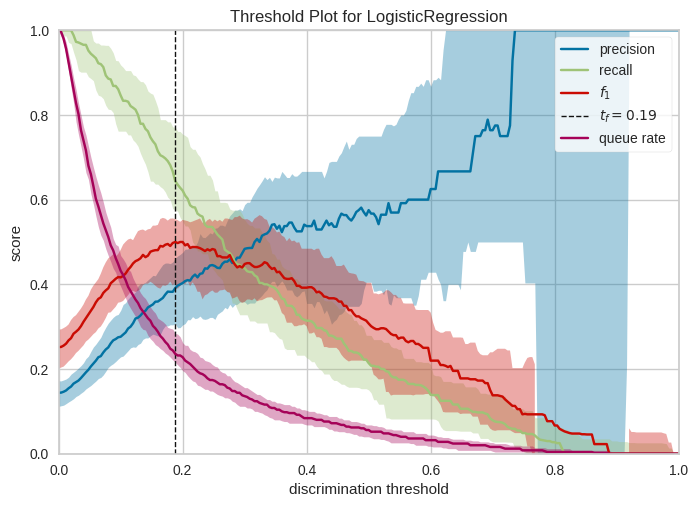

In [ ]:
from sklearn.linear_model import LogisticRegression

#Baseline model        
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

telecom_churn_prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

DecisionTree Classifier

In [ ]:
def treeplot(classifier, cols, classnames):
    #plot decision tree
    graph = Source(tree.export_graphviz(classifier, out_file=None, 
                                        rounded=True, proportion=False,
                                        feature_names = cols, 
                                        precision = 2,
                                        class_names = classnames,
                                        filled = True)
                  )
    display(graph)

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       713
           1       0.77      0.69      0.73       121

    accuracy                           0.93       834
   macro avg       0.86      0.83      0.84       834
weighted avg       0.92      0.93      0.92       834

Accuracy Score: 0.9256594724220624
Area under curve: 0.8295758812142848 



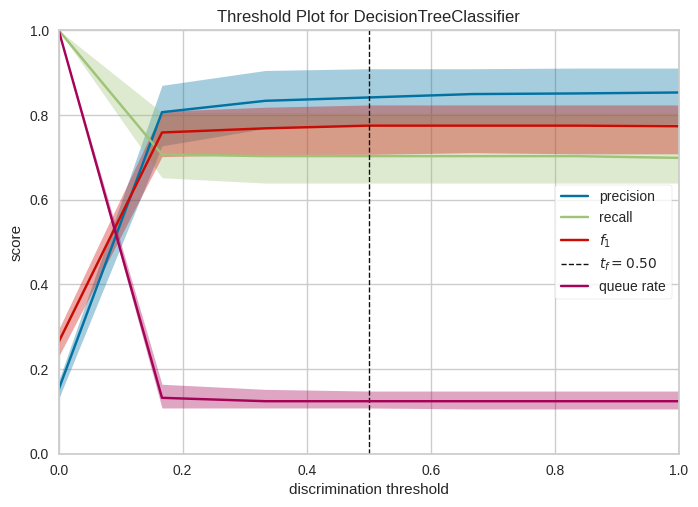

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG, display

decision_tree = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")

telecom_churn_prediction(decision_tree, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

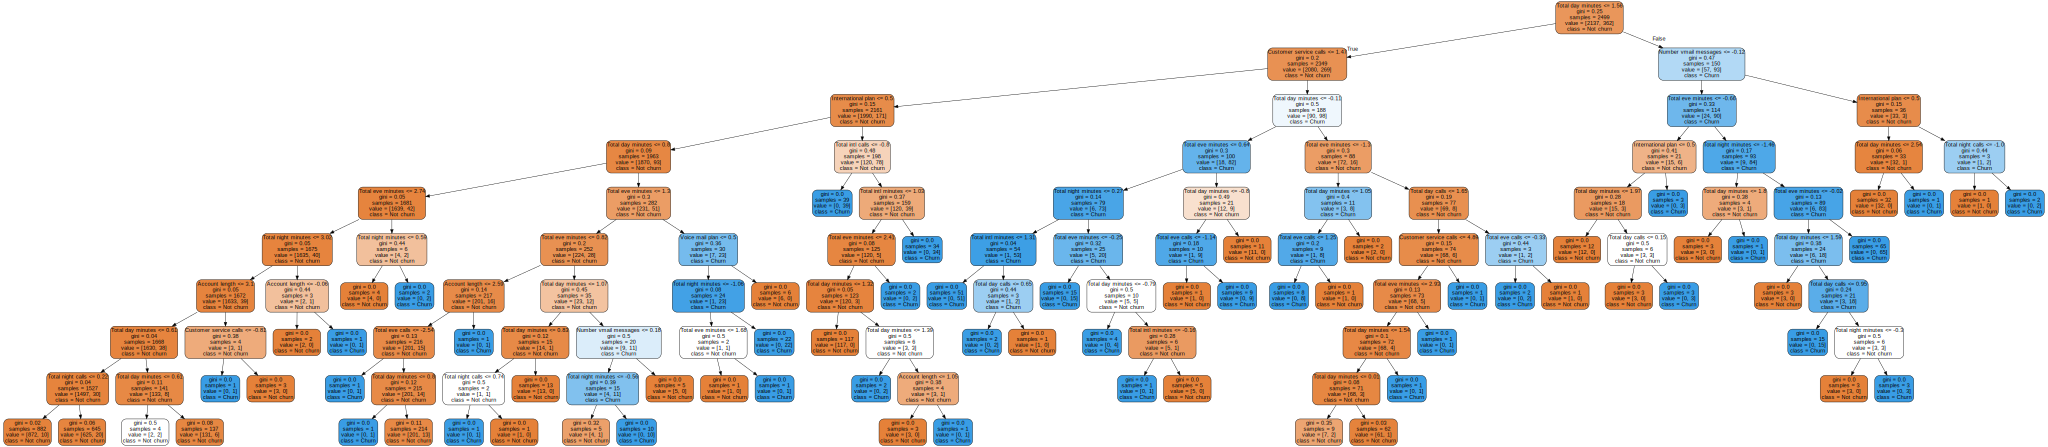

In [ ]:
#plot decision tree
treeplot(decision_tree, cols, ["Not churn", "Churn"])

RandomForest Classifier

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       713
           1       0.93      0.62      0.74       121

    accuracy                           0.94       834
   macro avg       0.93      0.81      0.85       834
weighted avg       0.94      0.94      0.93       834

Accuracy Score: 0.9376498800959233
Area under curve: 0.8057097817393623 



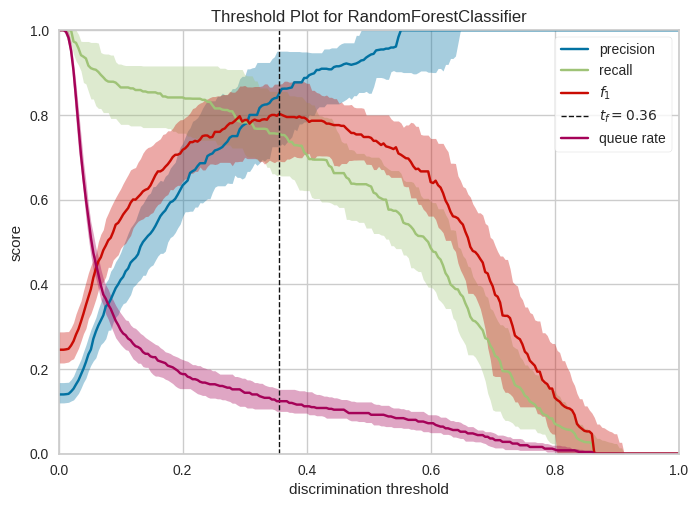

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100, random_state = 123,
                             max_depth = 9, criterion = "gini")

telecom_churn_prediction(rfc, x_train, x_test, y_train, y_test, 'features', threshold_plot=True)

Gaussian Naive Bayes

Algorithm: GaussianNB

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       713
           1       0.42      0.40      0.41       121

    accuracy                           0.83       834
   macro avg       0.66      0.65      0.66       834
weighted avg       0.83      0.83      0.83       834

Accuracy Score: 0.8333333333333334
Area under curve: 0.6520637974800922 



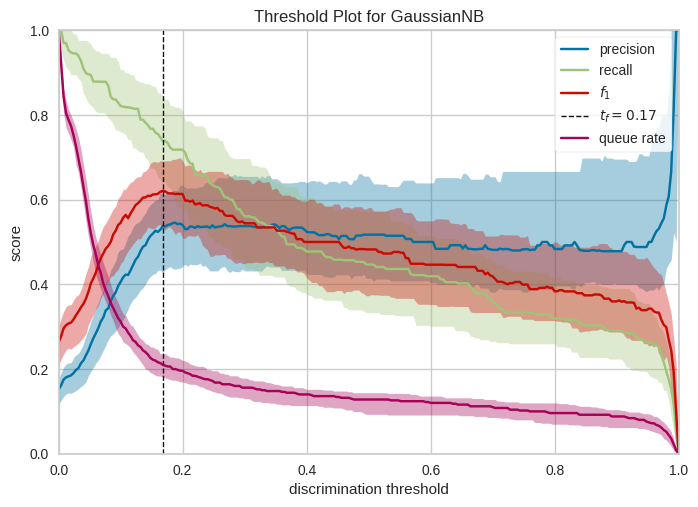

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(priors=None)

telecom_churn_prediction(gnb, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)

SVC

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       713
           1       0.00      0.00      0.00       121

    accuracy                           0.85       834
   macro avg       0.43      0.50      0.46       834
weighted avg       0.73      0.85      0.79       834

Accuracy Score: 0.854916067146283
Area under curve: 0.5 



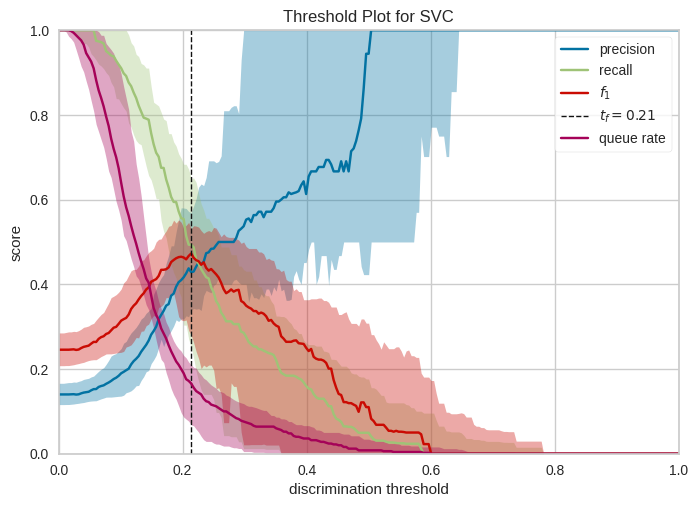

In [ ]:
from sklearn.svm import SVC

#Support vector classifier using linear hyper plane
svc_lin  = SVC(C=1.0, kernel='linear', probability=True, random_state=124)

telecom_churn_prediction(svc_lin, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)


SVC using "rbf"

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       713
           1       0.77      0.63      0.69       121

    accuracy                           0.92       834
   macro avg       0.85      0.80      0.82       834
weighted avg       0.91      0.92      0.92       834

Accuracy Score: 0.9184652278177458
Area under curve: 0.7979205545187951 



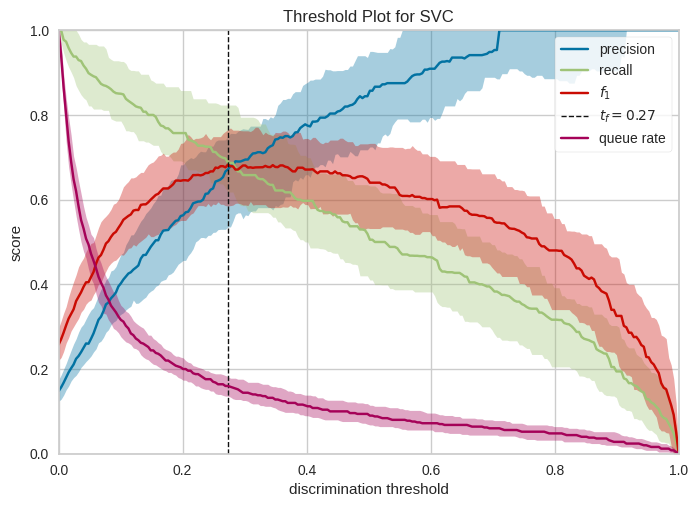

In [ ]:
#support vector classifier using non-linear hyper plane ("rbf")
svc_rbf  = SVC(C=10.0, kernel='rbf', gamma=0.1, probability=True, random_state=124)   

telecom_churn_prediction(svc_rbf, x_train, x_test, y_train, y_test, "None", threshold_plot=True)

In [ ]:
#putting all the model names, model classes and the used columns in a dictionary
models = {'Logistic (Baseline)': [logit, cols],
          'Decision Tree': [decision_tree, cols], 
          'Random Forest': [rfc, cols], 
          'Naive Bayes': [gnb, cols], 
          'SVM (linear)': [svc_lin, cols], 
          'SVM (rbf)': [svc_rbf, cols],
         }

In [ ]:
#gives model report in dataframe
def model_report(model, training_x, testing_x, training_y, testing_y, name):
    model = model.fit(training_x, training_y)
    predictions = model.predict(testing_x)
    accuracy = accuracy_score(testing_y, predictions)
    recallscore = recall_score(testing_y, predictions)
    precision = precision_score(testing_y, predictions)
    roc_auc = roc_auc_score(testing_y, predictions)
    f1score = f1_score(testing_y, predictions) 
    kappa_metric = cohen_kappa_score(testing_y, predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

In [ ]:
#outputs for all models over the training dataset
model_performances_train = pd.DataFrame() 
for name in models:
        model_performances_train = model_performances_train.append(model_report(models[name][0], x_train[models[name][1]], 
                                                                                x_test[models[name][1]], 
                                                                                y_train, y_test, name), ignore_index=True)
        
table_train = ff.create_table(np.round(model_performances_train, 4))
table_train.show(renderer="colab")

While we are in the process of manipulating the datasets, let's transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes/True and No/False to 1 and 0, respectively. All these tasks will be done using the following get_data function.


In [ ]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df

In [ ]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

Attritiondata = get_data(Attritiondata, removeCols=removeCols)

Let's take a quick look at the resulting datasets.

In [ ]:
import pandas as pd
pd.DataFrame(Attritiondata.take(5), columns=Attritiondata.columns).transpose()

,0,1,2,3,4
Account length,117.0,65.0,161.0,111.0,49.0
International plan,0.0,0.0,0.0,0.0,0.0
Voice mail plan,0.0,0.0,0.0,0.0,0.0
Number vmail messages,0.0,0.0,0.0,0.0,0.0
Total day minutes,184.5,129.1,332.9,110.4,119.3
Total day calls,97.0,137.0,67.0,103.0,117.0
Total eve minutes,351.6,228.5,317.8,137.3,215.1
Total eve calls,80.0,83.0,97.0,102.0,109.0
Total night minutes,215.8,208.8,160.6,189.6,178.7
Total night calls,90.0,111.0,128.0,105.0,90.0


In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(Attritiondata).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())


The two first rows of the training data RDD:
[LabeledPoint(0.0, [117.0,0.0,0.0,0.0,184.5,97.0,351.6,80.0,215.8,90.0,8.7,4.0,1.0]), LabeledPoint(1.0, [161.0,0.0,0.0,0.0,332.9,67.0,317.8,97.0,160.6,128.0,5.4,9.0,4.0])]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 4 <= 264.79999999999995)
   If (feature 12 <= 3.5)
    Predict: 0.0
   Else (feature 12 > 3.5)
    Predict: 1.0
  Else (feature 4 > 264.79999999999995)
   If (feature 3 <= 2.0)
    Predict: 1.0
   Else (feature 3 > 2.0)
    Predict: 0.0



In [ ]:
print("Feature 12 is the {}.".format(Attritiondata.columns[12]))
print("Feature 4 is the {}.".format(Attritiondata.columns[4]))

Feature 12 is the Customer service calls.
Feature 4 is the Total day minutes.


Model Evaluation

In [ ]:
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall) 
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Confusion Matrix
 [[533.  37.]
 [ 58.  50.]]
Precision of True     0.5747126436781609
Precision of False    0.9018612521150592
Weighted Precision    0.8497490843994471
Recall of True        0.46296296296296297
Recall of False       0.9350877192982456
Weighted Recall       0.8598820058997051
FMeasure of True      0.5128205128205128
FMeasure of False     0.9181739879414297
Weighted fMeasure     0.853604407833673
Accuracy              0.859882005899705


To check the above obtained results and comparing them with those that will be obtained using our new printAllMetrics function, let's displaying the confusion matrix that is used to compute all the variables of our new function:

In [ ]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   48|
|  0.0|           1.0|   37|
|  1.0|           0.0|   61|
|  0.0|           0.0|  532|
+-----+--------------+-----+

Precision of True     0.5747126436781609
Precision of False    0.9018612521150592
** Avg Precision      0.8497490843994471
Recall of True        0.46296296296296297
Recall of False       0.9350877192982456
** Avg Recall         0.859882005899705
F1 of True            0.5128205128205128
F1 of False           0.9181739879414297
** Avg F1             0.853604407833673
** Accuracy           0.859882005899705


In [ ]:
Attritiondata.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0| 2850|
|  1.0|  483|
+-----+-----+



Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames sampleBy function does this when provided with fractions of each sample type to be returned.

We are keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278. You can set seed for reproducibility.

In [ ]:
stratified_data = Attritiondata.sampleBy('Churn', fractions={0: Attritiondata.select("Churn").where('Churn == 1').count()/
                                                          Attritiondata.select("Churn").where('Churn == 0').count(), 1: 1.0}, seed = 5323)

stratified_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0|  502|
|  1.0|  483|
+-----+-----+



Let's build a new model using the evenly distributed data set and see how it performs.

In [ ]:
training_data, testing_data = labelData(stratified_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

print("========================================")

predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[84. 20.]
 [28. 60.]]
Precision of True     0.75
Precision of False    0.75
Weighted Precision    0.75
Recall of True        0.6818181818181818
Recall of False       0.8076923076923077
Weighted Recall       0.75
FMeasure of True      0.7142857142857143
FMeasure of False     0.7777777777777779
Weighted fMeasure     0.7486772486772487
Accuracy              0.75
Precision of True     0.75
Precision of False    0.7021276595744681
** Avg Precision      0.7263389581804842
Recall of True        0.6818181818181818
Recall of False       0.7674418604651163
** Avg Recall         0.7241379310344828
F1 of True            0.7142857142857143
F1 of False           0.7333333333333334
** Avg F1             0.7237000547345375
** Accuracy           0.7241379310344828


With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

> Indented block



In [ ]:
stratified_data.show(2)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|            65|               0.0|            0.0|                    0|            129.1|            137|            228.5|             83|              208.8|              111|              12.7|               6|                     4|  1.0|
|           161|    

Let's define a get_dummy function that transforms a given classical dataframe to a new other one composed of dense vectors reliable to be running with Spark ML.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

Once the required function is ready, let's define the needed numericCols list by removing the Churn column and transforming the datasets:

In [ ]:
test = spark.read.csv("/content/drive/MyDrive/Customer Churn Prediction/new/testing.csv", header='true', inferSchema='true')
test .printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [ ]:
print("The test dataset contains {} samples.".format(test.count()))

The test dataset contains 684 samples.


In [ ]:
final_test_data = get_data(test, removeCols=removeCols)

In [ ]:
numericCols = stratified_data.columns
numericCols.remove("Churn")

vectorized_data = get_dummy(Attritiondata, numericCols, "Churn")
vectorized_stratified_data = get_dummy(stratified_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(final_test_data, numericCols, "Churn")

Let's now looking the structure of one of the transformed datasets to see what has been happened by comparing it to the structure displayed above:

In [ ]:
vectorized_stratified_data.show(2, False)

+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|features                                                          |label|indexedFeatures                                                   |indexedLabel|
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|[65.0,0.0,0.0,0.0,129.1,137.0,228.5,83.0,208.8,111.0,12.7,6.0,4.0]|1.0  |[65.0,0.0,0.0,0.0,129.1,137.0,228.5,83.0,208.8,111.0,12.7,6.0,4.0]|1.0         |
|[161.0,0.0,0.0,0.0,332.9,67.0,317.8,97.0,160.6,128.0,5.4,9.0,4.0] |1.0  |[161.0,0.0,0.0,0.0,332.9,67.0,317.8,97.0,160.6,128.0,5.4,9.0,4.0] |1.0         |
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
only showing top 2 rows



 K-fold cross validation

In [ ]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    underROC_train = []
    underROC_test = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)  
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        underROC_train.append(evaluatorB.evaluate(predict_train))
        underROC_test.append(evaluatorB.evaluate(predict_test))
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), 
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  
    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))
  
    return cvResults

In [ ]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC',LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_data, vectorized_test_data=vectorized_final_test_data, 
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_data, 
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers, 
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

Model Evaluation

In [ ]:
cvResults_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.594,0.583,0.863,0.854,0.863,0.854,0.835,0.821,0.863,0.854
NB,0.608,0.634,0.629,0.632,0.629,0.632,0.800,0.812,0.629,0.632
SVC,0.500,0.500,0.855,0.855,0.855,0.855,0.731,0.731,0.855,0.855
DT,0.858,0.895,0.950,0.963,0.950,0.963,0.949,0.963,0.950,0.963
RF,0.820,0.812,0.946,0.944,0.946,0.944,0.947,0.947,0.946,0.944


Metrics computed using the stratified data (stratified_CV_data) for the training step:

In [ ]:
cvResults_stratified_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.763,0.777,0.763,0.776,0.763,0.776,0.763,0.869,0.763,0.776
NB,0.602,0.618,0.602,0.598,0.602,0.598,0.602,0.807,0.602,0.598
SVC,0.741,0.759,0.741,0.760,0.741,0.760,0.741,0.862,0.741,0.760
DT,0.893,0.891,0.894,0.906,0.894,0.906,0.899,0.926,0.894,0.906
RF,0.888,0.879,0.888,0.871,0.888,0.871,0.889,0.914,0.888,0.871


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_data)  
pred_train = clfModel.transform(vectorized_stratified_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.6024474355396268
Weighted Recall       0.6020304568527919
F1                    0.6020378401496147
Accuracy              0.6020304568527919
Precision of True     0.590818363273453
Precision of False    0.6136363636363636
** Avg Precision      0.6024474355396268
Recall of True        0.6128364389233955
Recall of False       0.5916334661354582
** Avg Recall         0.6020304568527919
F1 of True            0.6016260162601627
F1 of False           0.6024340770791075
** Avg F1             0.6020378401496148
** Accuracy           0.6020304568527919


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')


clfModel = clf.fit(vectorized_stratified_data)  
pred_train = clfModel.transform(vectorized_stratified_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.8986643743022468
Weighted Recall       0.8944162436548224
F1                    0.8940123670588299
Accuracy              0.8944162436548223
Precision of True     0.9396751740139211
Precision of False    0.8592057761732852
** Avg Precision      0.8986643743022469
Recall of True        0.8385093167701864
Recall of False       0.9482071713147411
** Avg Recall         0.8944162436548223
F1 of True            0.886214442013129
F1 of False           0.9015151515151516
** Avg F1             0.8940123670588299
** Accuracy           0.8944162436548223


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_data)  
pred_train = clfModel.transform(vectorized_stratified_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.7634563788643671
Weighted Recall       0.7634517766497462
F1                    0.7633902874489755
Accuracy              0.7634517766497462
Precision of True     0.7637130801687764
Precision of False    0.7632093933463796
** Avg Precision      0.763456378864367
Recall of True        0.7494824016563147
Recall of False       0.7768924302788844
** Avg Recall         0.7634517766497462
F1 of True            0.7565308254963428
F1 of False           0.769990128331688
** Avg F1             0.7633902874489755
** Accuracy           0.7634517766497462


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_data)  
pred_train = clfModel.transform(vectorized_stratified_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.7411923065395787
Weighted Recall       0.7411167512690355
F1                    0.7411354330068094
Accuracy              0.7411167512690355
Precision of True     0.7336065573770492
Precision of False    0.7484909456740443
** Avg Precision      0.7411923065395787
Recall of True        0.7412008281573499
Recall of False       0.7410358565737052
** Avg Recall         0.7411167512690355
F1 of True            0.7373841400617919
F1 of False           0.7447447447447447
** Avg F1             0.7411354330068094
** Accuracy           0.7411167512690355


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_data)  
pred_train = clfModel.transform(vectorized_stratified_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.8890063038438091
Weighted Recall       0.8883248730964467
F1                    0.888220870630408
Accuracy              0.8883248730964467
Precision of True     0.9045553145336226
Precision of False    0.8740458015267175
** Avg Precision      0.8890063038438091
Recall of True        0.8633540372670807
Recall of False       0.9123505976095617
** Avg Recall         0.8883248730964467
F1 of True            0.8834745762711864
F1 of False           0.8927875243664717
** Avg F1             0.8882208706304079
** Accuracy           0.8883248730964467
